In [1]:
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
from util import *
import matplotlib.pyplot as plt
%matplotlib inline
import gc
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# I. Initial processing


Loading data

In [2]:
# Loading Train Dataset
train_transaction = pd.read_csv('dataset/train_transaction.csv')
train_identity = pd.read_csv('dataset/train_identity.csv')

Merging transaction and identity files


In [3]:
# Merging the transaction and identity dataset
train_data = train_transaction.merge(train_identity, how='left', on='TransactionID')
del train_transaction, train_identity

gc.collect()
train_data.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


Checking for Duplicate Rows in the training set

In [4]:
duplicate_rows = train_data[train_data.duplicated()]  
print("Duplicate Rows :", duplicate_rows)

Duplicate Rows : Empty DataFrame
Columns: [TransactionID, isFraud, TransactionDT, TransactionAmt, ProductCD, card1, card2, card3, card4, card5, card6, addr1, addr2, dist1, dist2, P_emaildomain, R_emaildomain, C1, C2, C3, C4, C5, C6, C7, C8, C9, C10, C11, C12, C13, C14, D1, D2, D3, D4, D5, D6, D7, D8, D9, D10, D11, D12, D13, D14, D15, M1, M2, M3, M4, M5, M6, M7, M8, M9, V1, V2, V3, V4, V5, V6, V7, V8, V9, V10, V11, V12, V13, V14, V15, V16, V17, V18, V19, V20, V21, V22, V23, V24, V25, V26, V27, V28, V29, V30, V31, V32, V33, V34, V35, V36, V37, V38, V39, V40, V41, V42, V43, V44, V45, ...]
Index: []

[0 rows x 434 columns]


Saving the merged train and test dataset into pickle format

In [5]:
train_data.to_pickle('dataset/merged_train.pkl')

del train_data
gc.collect()

0

# II. Time features

## Initialization

Loading the merged train and test dataset

In [6]:
train_data = pd.read_pickle('dataset/merged_train.pkl')

## Generate time features

Create day column

In [7]:
train_data['day'] = (train_data['TransactionDT']//(3600*24)-1)%7

<AxesSubplot:xlabel='day', ylabel='percentage'>

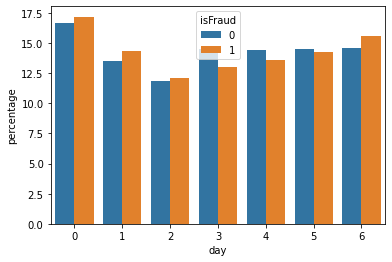

In [8]:
train_day = (train_data.groupby(['isFraud'])['day']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('day'))
sns.barplot(x="day", y="percentage", hue="isFraud", data=train_day)

Create hour column

In [9]:
train_data['hour'] = (train_data['TransactionDT']//(3600))%24

<AxesSubplot:xlabel='hour', ylabel='percentage'>

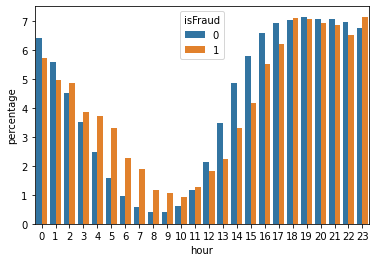

In [10]:
train_hour = (train_data.groupby(['isFraud'])['hour']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('hour'))
sns.barplot(x="hour", y="percentage", hue="isFraud", data=train_hour)

# III. Resolving Nan issues

In [11]:
X_train = train_data

In [12]:
columns_def = pd.DataFrame({"NA_count":X_train.isnull().sum().sort_values(ascending=False)})
columns_def["Per"]=columns_def["NA_count"]/len(X_train)
columns_def.head(20)

,NA_count,Per
id_24,585793,0.991962
id_25,585408,0.991310
id_08,585385,0.991271
id_07,585385,0.991271
id_21,585381,0.991264
id_26,585377,0.991257
id_27,585371,0.991247
id_23,585371,0.991247
id_22,585371,0.991247
dist2,552913,0.936284


Remove columns with >= 99% missing values

In [13]:
train = X_train.dropna(axis=1, how='any', thresh=0.01*X_train.shape[0], subset=None, inplace=False)

todrop = X_train.columns.symmetric_difference(train.columns)
print(todrop)

X_train = train

Index(['id_07', 'id_08', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26',
       'id_27'],
      dtype='object')


In [14]:
print("Train Data Shape : {} \n".format(X_train.shape))

Train Data Shape : (590540, 427) 



In [15]:
X_train.head(20)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,day,hour
0,2987000,0,86400,68.500,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
1,2987001,0,86401,29.000,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
2,2987002,0,86469,59.000,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
3,2987003,0,86499,50.000,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
4,2987004,0,86506,50.000,H,4497,514.0,150.0,mastercard,102.0,...,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M,0,0
5,2987005,0,86510,49.000,W,5937,555.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
6,2987006,0,86522,159.000,W,12308,360.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
7,2987007,0,86529,422.500,W,12695,490.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
8,2987008,0,86535,15.000,H,2803,100.0,150.0,visa,226.0,...,1334x750,match_status:1,T,F,F,T,mobile,iOS Device,0,0
9,2987009,0,86536,117.000,W,17399,111.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0


Replace missing values in numeric columns with mean of column

In [16]:
column_means = X_train.mean(numeric_only=True)
X_train = X_train.fillna(column_means)
X_train.head(20)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,day,hour
0,2987000,0,86400,68.500,W,13926,362.555488,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
1,2987001,0,86401,29.000,W,2755,404.000000,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
2,2987002,0,86469,59.000,W,4663,490.000000,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
3,2987003,0,86499,50.000,W,18132,567.000000,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
4,2987004,0,86506,50.000,H,4497,514.000000,150.0,mastercard,102.0,...,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M,0,0
5,2987005,0,86510,49.000,W,5937,555.000000,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
6,2987006,0,86522,159.000,W,12308,360.000000,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
7,2987007,0,86529,422.500,W,12695,490.000000,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
8,2987008,0,86535,15.000,H,2803,100.000000,150.0,visa,226.0,...,1334x750,match_status:1,T,F,F,T,mobile,iOS Device,0,0
9,2987009,0,86536,117.000,W,17399,111.000000,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0


Replacing missing values in categoric columns with the mode of the column

In [17]:
X_train = X_train.apply(lambda x: x.fillna(x.value_counts().index[0]))

In [18]:
X_train.head(20)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,day,hour
0,2987000,0,86400,68.500,W,13926,362.555488,150.0,discover,142.0,...,1920x1080,match_status:2,T,F,T,F,desktop,Windows,0,0
1,2987001,0,86401,29.000,W,2755,404.000000,150.0,mastercard,102.0,...,1920x1080,match_status:2,T,F,T,F,desktop,Windows,0,0
2,2987002,0,86469,59.000,W,4663,490.000000,150.0,visa,166.0,...,1920x1080,match_status:2,T,F,T,F,desktop,Windows,0,0
3,2987003,0,86499,50.000,W,18132,567.000000,150.0,mastercard,117.0,...,1920x1080,match_status:2,T,F,T,F,desktop,Windows,0,0
4,2987004,0,86506,50.000,H,4497,514.000000,150.0,mastercard,102.0,...,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M,0,0
5,2987005,0,86510,49.000,W,5937,555.000000,150.0,visa,226.0,...,1920x1080,match_status:2,T,F,T,F,desktop,Windows,0,0
6,2987006,0,86522,159.000,W,12308,360.000000,150.0,visa,166.0,...,1920x1080,match_status:2,T,F,T,F,desktop,Windows,0,0
7,2987007,0,86529,422.500,W,12695,490.000000,150.0,visa,226.0,...,1920x1080,match_status:2,T,F,T,F,desktop,Windows,0,0
8,2987008,0,86535,15.000,H,2803,100.000000,150.0,visa,226.0,...,1334x750,match_status:1,T,F,F,T,mobile,iOS Device,0,0
9,2987009,0,86536,117.000,W,17399,111.000000,150.0,mastercard,224.0,...,1920x1080,match_status:2,T,F,T,F,desktop,Windows,0,0


# IV. Label Encoding


Storing Categorical and Numerical Feature Names 

In [19]:
catf, numf = cat_num_features(X_train)
categorical_feature_indices = [X_train.columns.get_loc(f) for f in catf]

Label Encoding Categorical Features

In [20]:
# Imputing the missing values of Categorical Columns with "missing"
X_train[catf] = X_train[catf].fillna('missing')

# Label Encoding Categorical Features
X_train= label_encode(X_train, catf)

In [21]:
X_train.head(20)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,day,hour
0,2987000,0,86400,68.500,4,3417,262,42,1,38,...,132,3,1,0,1,0,0,1598,0,0
1,2987001,0,86401,29.000,4,7922,304,42,2,2,...,132,3,1,0,1,0,0,1598,0,0
2,2987002,0,86469,59.000,4,9383,390,42,3,58,...,132,3,1,0,1,0,0,1598,0,0
3,2987003,0,86499,50.000,4,6991,467,42,2,14,...,132,3,1,0,1,0,0,1598,0,0
4,2987004,0,86506,50.000,1,9262,414,42,2,2,...,164,3,1,0,1,1,1,954,0,0
5,2987005,0,86510,49.000,4,10366,455,42,3,109,...,132,3,1,0,1,0,0,1598,0,0
6,2987006,0,86522,159.000,4,2009,259,42,3,58,...,132,3,1,0,1,0,0,1598,0,0
7,2987007,0,86529,422.500,4,2360,390,42,3,109,...,132,3,1,0,1,0,0,1598,0,0
8,2987008,0,86535,15.000,1,7962,0,42,3,109,...,48,2,1,0,0,1,1,1727,0,0
9,2987009,0,86536,117.000,4,6370,10,42,2,107,...,132,3,1,0,1,0,0,1598,0,0


Saving the output datasets

In [22]:
X_train.to_pickle('dataset/intermidiate_train.pkl')

# V. Dimensionality reduction

## Principal Component Analysis (PCA)

In [23]:
X_train = pd.read_pickle('dataset/intermidiate_train.pkl')

In [24]:
X_train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,day,hour
0,2987000,0,86400,68.5,4,3417,262,42,1,38,...,132,3,1,0,1,0,0,1598,0,0
1,2987001,0,86401,29.0,4,7922,304,42,2,2,...,132,3,1,0,1,0,0,1598,0,0
2,2987002,0,86469,59.0,4,9383,390,42,3,58,...,132,3,1,0,1,0,0,1598,0,0
3,2987003,0,86499,50.0,4,6991,467,42,2,14,...,132,3,1,0,1,0,0,1598,0,0
4,2987004,0,86506,50.0,1,9262,414,42,2,2,...,164,3,1,0,1,1,1,954,0,0


In [25]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

y = X_train['isFraud']
X = X_train.drop(['isFraud', 'TransactionID'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=34, stratify=y)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)


In [30]:
print (X_train.head(50))

        ft_0       ft_1      ft_2      ft_3      ft_4      ft_5      ft_6  \
0   0.246714  21.052847 -1.732426  0.405449 -0.458130  1.121409  1.739514   
1  -0.559599  -2.702689  0.106453 -0.080004 -0.506272 -0.087697  0.911281   
2  -1.127139   2.291133 -0.649408 -2.460059 -2.157716  5.517973 -0.981031   
3   0.123061  -3.193012  0.112778  0.287264  0.100322 -0.055981  1.731105   
4   0.089173  -2.227152  0.639835  0.358173  0.771907  0.260892  4.046126   
5  -1.867514   2.518375  0.471684 -3.214262 -0.567053  7.061334  3.539198   
6  -0.680571  -4.000344  0.104459 -0.192998 -0.006098 -0.360012 -1.209686   
7  -0.254598  -2.043957  0.172346  0.086945 -0.183228  0.015207  1.810629   
8  -0.644002  -2.943165  0.114538 -0.104295 -0.483839 -0.150786  0.813136   
9  -0.145505  -0.642173  0.572697 -0.502446 -0.437254 -0.822278  1.578357   
10 -0.541189  -1.308635 -0.080898  0.031919 -0.407848  0.081743  0.069919   
11 -0.596053   0.653575  1.306250 -1.203393 -0.776941  3.819255  2.454356   

In [26]:
# Applying PCA function on training
# and testing set of X component
from sklearn.decomposition import PCA
 
columns = ['ft_%i' % i for i in range(400)]

pca = PCA(n_components = 400)

train = pd.DataFrame(pca.fit_transform(X_train), columns=columns)

test = pd.DataFrame(pca.transform(X_test), columns=columns)
 
explained_variance = pca.explained_variance_ratio_


In [27]:
train.head(20)
X_train = train
X_test = test

# VI. Balancing data

In [28]:
# smote = SMOTE(random_state=42)
# X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
over = SMOTE(sampling_strategy=0.5)
under = RandomUnderSampler(sampling_strategy=0.041)
steps = [('u', under), ('o', over)]
pipeline = Pipeline(steps=steps)
# transform the dataset
X_train_res, y_train_res = pipeline.fit_resample(X_train, y_train)

y_train_res.value_counts()
    

0    352780
1    176390
Name: isFraud, dtype: int64

In [29]:
X_train_res.to_pickle('dataset/X_train.pkl')
y_train_res.to_pickle('dataset/y_train.pkl')

X_test.to_pickle('dataset/X_test.pkl')
y_test.to_pickle('dataset/y_test.pkl')